# Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import librosa
import librosa.display
from IPython.display import Audio

In [3]:
import os
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Analysing a sound sample

In [4]:
name = '03-01-02-01-01-02-06.wav'
audio_data , audio_sample_rate = librosa.load(name)

The audio_data is the mathematical representation of the sound wave in mono channel.

In [5]:
audio_data

array([-8.3684625e-07, -1.9803090e-06,  1.0179916e-05, ...,
        8.9860987e-05,  8.5175649e-05,  0.0000000e+00], dtype=float32)

The sample rate defines how many times per second a sound is sampled.

In [6]:
audio_sample_rate

22050

In [7]:
Audio(name)

## Waveplot and Spectrogram

A waveplot tells us about the loudness of the audio at a given time.

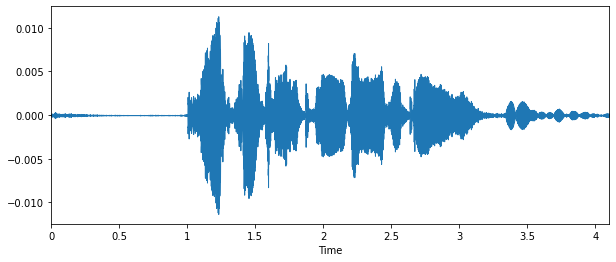

In [8]:
plt.figure(figsize=(10,4))
librosa.display.waveplot(audio_data,sr = audio_sample_rate)

Spectogram is a visual representation of frequencies changing with respect to time for given audio/music signals.

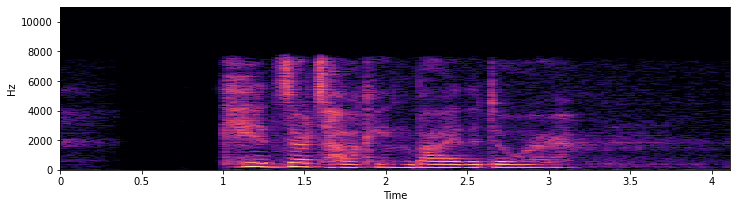

In [9]:
# We need to convert the audio data into Short term fourier transform
X = librosa.stft(audio_data)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(12, 3))
librosa.display.specshow(Xdb, sr=audio_sample_rate, x_axis='time', y_axis='hz') 

# _______________________________________________________

# Dataset Preparation

![Revdess Naming Schema](revdess_naming_schema.jpeg "Title")

In [10]:
print(os.listdir('REVDESS Dataset'))

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [11]:
dir_list = os.listdir('REVDESS Dataset')
file_path=[]
file_emotion=[]

for dir in dir_list:
    actor = os.listdir('REVDESS Dataset' + '/' + dir)
    for file in actor:
        emotion = file.split('.')[0]
        emotion = int(emotion.split('-')[2])
        file_emotion.append(emotion)
        file_path.append('REVDESS Dataset' + '/' + dir + '/' + file)

In [12]:
emotions = pd.DataFrame(file_emotion , columns={'Emotions'})

In [13]:
paths = pd.DataFrame(file_path,columns={'File_Paths'})

In [17]:
revdess_data = pd.concat([paths,emotions], axis=1)

revdess_data.Emotions.replace({
    1:'neutral', 
    2:'calm', 
    3:'happy', 
    4:'sad', 
    5:'angry', 
    6:'fear', 
    7:'disgust', 
    8:'surprise'}, inplace=True)

revdess_data.head(10)

,File_Paths,Emotions
0,REVDESS Dataset/Actor_01/03-01-01-01-01-01-01.wav,neutral
1,REVDESS Dataset/Actor_01/03-01-01-01-01-02-01.wav,neutral
2,REVDESS Dataset/Actor_01/03-01-01-01-02-01-01.wav,neutral
3,REVDESS Dataset/Actor_01/03-01-01-01-02-02-01.wav,neutral
4,REVDESS Dataset/Actor_01/03-01-02-01-01-01-01.wav,calm
5,REVDESS Dataset/Actor_01/03-01-02-01-01-02-01.wav,calm
6,REVDESS Dataset/Actor_01/03-01-02-01-02-01-01.wav,calm
7,REVDESS Dataset/Actor_01/03-01-02-01-02-02-01.wav,calm
8,REVDESS Dataset/Actor_01/03-01-02-02-01-01-01.wav,calm
9,REVDESS Dataset/Actor_01/03-01-02-02-01-02-01.wav,calm


In [18]:
revdess_data.shape

(1440, 2)

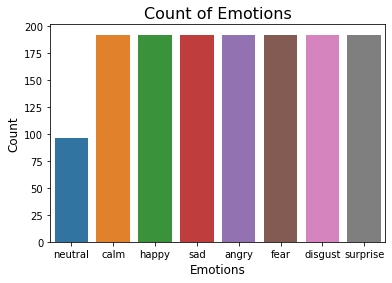

In [19]:
plt.title('Count of Emotions', size=16)
sns.countplot(x = revdess_data.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

# Data Augmentation

These are the techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It helps in reducing the overfitting of the model.

In [20]:
Audio(name, rate=audio_sample_rate)

### Injecting white noise

In [21]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

In [22]:
n = noise(audio_data)
Audio(n,rate=audio_sample_rate)

## Pitch variation

In [23]:
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [24]:
p = pitch(audio_data,audio_sample_rate)
Audio(p,rate=audio_sample_rate)

## Stretching the audio

In [25]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

In [26]:
s = stretch(audio_data)
Audio(s,rate=audio_sample_rate)

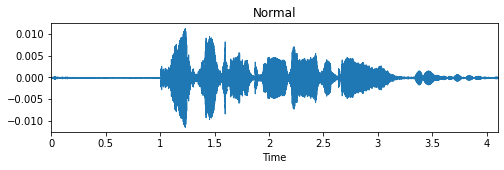

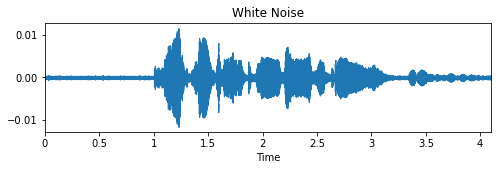

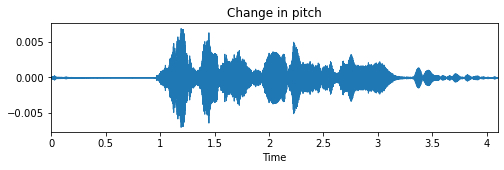

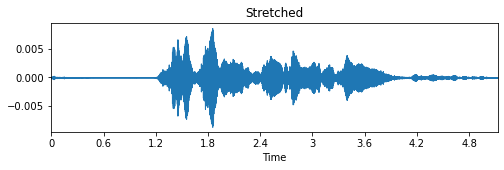

In [27]:
plt.figure(figsize=(8,2))
plt.title('Normal')
librosa.display.waveplot(audio_data,sr = audio_sample_rate)

plt.figure(figsize=(8,2))
plt.title('White Noise')
librosa.display.waveplot(n,sr = audio_sample_rate)

plt.figure(figsize=(8,2))
plt.title('Change in pitch')
librosa.display.waveplot(p,sr = audio_sample_rate)

plt.figure(figsize=(8,2))
plt.title('Stretched')
librosa.display.waveplot(s,sr = audio_sample_rate)

# Extracting the Mel Frequency Capstral Coefficients

In [28]:
def extract_features(data):
    
    result=np.array([])
    
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=audio_sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 
    
    #rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #result = np.hstack((result, rms))
    
    return result

In [29]:
def get_features(path):
    
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, audio_sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) 
    
    return result

In [30]:
X, Y = [], []
for path, emotion in zip(revdess_data.File_Paths, revdess_data.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [31]:
features = pd.DataFrame(X)
features['Labels'] = Y

In [32]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,Labels
0,-655.344543,86.649864,-12.361261,28.343275,-0.276913,9.111378,-10.830962,-0.023427,-17.030333,-3.272646,...,-5.887830,4.827703,-7.893807,3.420066,-1.663579,-3.320956,-4.437192,-0.790467,-2.032093,neutral
1,-533.730759,51.443569,1.675820,13.499841,5.223594,-0.238236,-5.821433,-6.977637,-12.597257,-6.332307,...,-3.962192,-0.511738,-3.311194,-0.781790,-0.801449,-4.343508,-3.916152,-0.362990,-2.421582,neutral
2,-724.307190,84.484085,-14.169809,31.049458,-3.062177,9.604401,-14.447046,-0.219916,-20.591162,2.434901,...,-4.020089,3.011852,-8.109156,3.908099,-5.972445,-3.686382,-5.658265,2.423278,-4.886253,neutral
3,-645.409851,87.810638,-17.773392,33.468960,-0.936478,8.191232,-9.919904,-3.311972,-18.590483,-2.199426,...,-6.660093,3.893641,-8.572474,2.928271,-3.344517,-3.604978,-4.101902,-1.308776,-0.581940,neutral
4,-421.061744,25.119861,8.659624,10.517897,5.371149,-0.088887,-3.251166,-7.291437,-9.268096,-5.303988,...,-1.897816,-1.687062,-2.277290,-1.405238,-1.140765,-3.156847,-2.541128,-0.274245,-1.597092,neutral


In [33]:
features.to_csv('Features.csv')

# Splitting the dependent and independent variables

In [34]:
X = features.iloc[: ,:-1].values
y = features['Labels'].values

# Encoding the categorical dependent variable

In [35]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y = encoder.fit_transform(np.array(y).reshape(-1,1)).toarray()

# Scaling the data

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [37]:
X

array([[-1.12968548,  0.64859579,  0.42329927, ...,  0.04095187,
        -0.04640884,  0.25465235],
       [-0.25761885, -0.55355424,  1.08309995, ...,  0.15662377,
         0.0473403 ,  0.1731279 ],
       [-1.62420197,  0.57464335,  0.33829006, ..., -0.23012901,
         0.65839171, -0.34275477],
       ...,
       [ 0.20113967,  0.09627014, -0.44758709, ...,  1.84257488,
         0.98197699,  0.79569143],
       [ 1.4046447 , -1.50490015,  0.92001147, ...,  2.07114849,
         0.59173183,  1.0135226 ],
       [-0.15648521,  0.03331315, -0.5539422 , ...,  1.59939491,
         1.58521066,  0.80923046]])

# Splitting the training and test sets

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3240, 20), (3240, 8), (1080, 20), (1080, 8))

# MLP CLASSIFIER

In [39]:
from sklearn.neural_network import MLPClassifier

In [40]:
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=800)

In [41]:
model.fit(X_train,y_train)

C:\Users\Hp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=800)

In [42]:
y_pred = model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred)
print(y_pred)

[['angry']
 ['angry']
 ['disgust']
 ...
 ['angry']
 ['calm']
 ['angry']]


# Confusion Matrix and Classification Report

In [53]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

In [54]:
df.head(10)

,Predicted Labels,Actual Labels
0,angry,angry
1,angry,fear
2,disgust,disgust
3,sad,sad
4,angry,surprise
5,angry,surprise
6,angry,disgust
7,angry,angry
8,surprise,neutral
9,sad,sad


In [93]:
from sklearn.metrics import classification_report,confusion_matrix

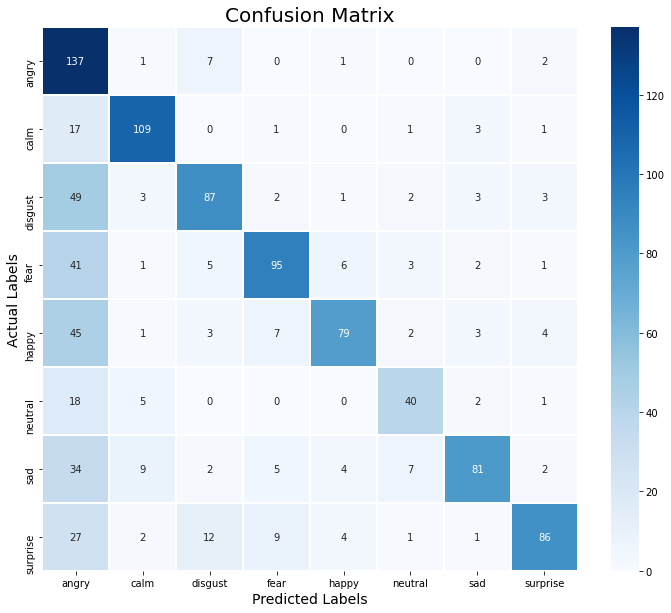

In [55]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.37      0.93      0.53       148
        calm       0.83      0.83      0.83       132
     disgust       0.75      0.58      0.65       150
        fear       0.80      0.62      0.70       154
       happy       0.83      0.55      0.66       144
     neutral       0.71      0.61      0.66        66
         sad       0.85      0.56      0.68       144
    surprise       0.86      0.61      0.71       142

    accuracy                           0.66      1080
   macro avg       0.75      0.66      0.68      1080
weighted avg       0.75      0.66      0.68      1080



# Predicting the Emotion of a single audio file.

In [91]:
def single_pred(audio):
    test_data , test_audio_sample_rate = librosa.load(audio)
    features = extract_features(test_data)
    features = features.reshape(1,20)
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    result = model.predict(features)
    return encoder.inverse_transform(result)

In [92]:
single_pred(r'03-01-02-01-01-02-06.wav')

array([['angry']], dtype=object)